[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1ZvQu40QCNUOc-cl1MYzIqO6rrwXXKrbI)

Author:
- **Safouane El Ghazouali**,
- Ph.D. in AI,
- Senior data scientist and researcher at TOELT LLC,
- Lecturer at HSLU

# -----  -----  -----  -----  -----  -----  -----  -----

# Hands-on: Finetuning a Pre-trained Transformer Model for Image Classification

In this notebook, we'll finetune a pre-trained Vision Transformer (ViT) model on the CIFAR-10 dataset using PyTorch and the timm library. The CIFAR-10 dataset contains 10 classes with 50,000 training images and 10,000 test images.

![CIFAR10-Example1](https://docs.pytorch.org/tutorials/_images/cifar10.png)

### Why Finetune?
- **Transfer Learning**: Leverage pre-trained weights for better performance.
- **Efficiency**: Less data and time than training from scratch.
- **Domain-Specific**: Adapt to general image classification.

### What You'll Learn
- Loading the CIFAR-10 dataset.
- Preparing a pre-trained ViT for finetuning.
- Training and evaluating the model.
- Plotting training loss over epochs.
- Evaluating on a single image.

# 🧰 Environment Setup

Install timm, torch, and torchvision if needed. We'll use GPU acceleration in Colab.

In [1]:
!pip install -q timm torch torchvision matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 50.5 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import torchvision
import timm
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

# Enable CUDA debugging
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print(f'PyTorch version: {torch.__version__}')
print(f'Torchvision version: {torchvision.__version__}')
print(f'TIMM version: {timm.__version__}')

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
TIMM version: 1.0.19


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Explanation
# device: Determines if we use GPU (cuda) or CPU for computations.

Using device: cuda


# 📊 Loading the Dataset

Load the CIFAR-10 dataset (10 classes, 50,000 training images, 10,000 test images).

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ViT input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

# Verify dataset sizes and labels
print(f'Train dataset size: {len(train_dataset)} images, {len(train_dataset.classes)} classes')
print(f'Test dataset size: {len(test_dataset)} images, {len(test_dataset.classes)} classes')

# Check label range
train_labels = [label for _, label in train_dataset]
test_labels = [label for _, label in test_dataset]
print(f'Train label range: min={min(train_labels)}, max={max(train_labels)}')
print(f'Test label range: min={min(test_labels)}, max={max(test_labels)}')

# Explanation
# transform: Preprocesses images to match ViT input requirements (224x224).
# train_dataset: CIFAR-10 training set (50,000 images, 10 classes).
# test_dataset: CIFAR-10 test set (10,000 images, 10 classes).
# train_loader/test_loader: Batched data with num_workers and pin_memory for efficient GPU loading.
# Label check: Ensures labels are 0-9, matching the 10 classes.

100%|██████████| 170M/170M [00:03<00:00, 47.0MB/s]


Train dataset size: 50000 images, 10 classes
Test dataset size: 10000 images, 10 classes
Train label range: min=0, max=9
Test label range: min=0, max=9


# 📦 Loading a Pre-trained Model for Finetuning

Load a pre-trained ViT and configure it for 10 classes.

In [6]:
num_classes = len(train_dataset.classes)  # 10 classes
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=num_classes)
model.to(device)
model.eval()

# Explanation
# model: Pre-trained ViT with head modified for 10 classes.
# to(device): Moves model to GPU if available.

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Explanation
# criterion: Loss function for multi-class classification.
# optimizer: Adam optimizer with a low learning rate for finetuning.

Epoch 1/1: 100%|██████████| 782/782 [25:34<00:00,  1.96s/it]


Epoch 1/1, Loss: 0.1751


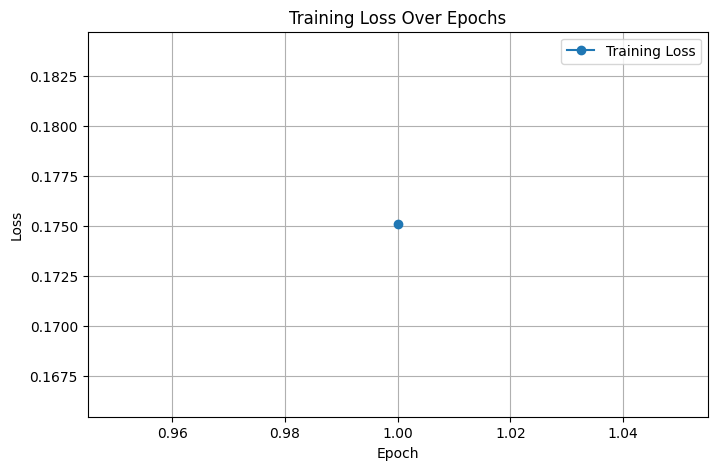

In [10]:
epochs = 1
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Plot training loss
plt.figure(figsize=(8, 5))
plt.plot(range(1, epochs + 1), train_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Explanation
# epochs: 4 passes over the dataset for better convergence.
# train_losses: Tracks average loss per epoch for visualization.
# Plot: Visualizes loss trend to monitor training progress.

In [11]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating'):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Explanation
# correct/total: Counts accurate predictions for accuracy metric.

Evaluating: 100%|██████████| 157/157 [01:44<00:00,  1.51it/s]

Test Accuracy: 95.64%


True class: truck (label: 9)
Predicted class: truck (label: 9)


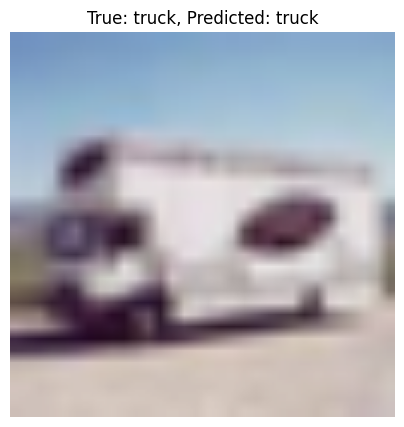

In [13]:
import random

# Get a random image from the test set
random_idx = random.randint(0, len(test_dataset) - 1)
image, true_label = test_dataset[random_idx]

# Prepare image for prediction
image = image.unsqueeze(0).to(device)  # Add batch dimension

# Predict
model.eval()
with torch.no_grad():
    output = model(image)
    _, predicted = torch.max(output, 1)
    predicted_label = predicted.item()

# Map labels to class names
class_names = test_dataset.classes
true_class = class_names[true_label]
predicted_class = class_names[predicted_label]

print(f'True class: {true_class} (label: {true_label})')
print(f'Predicted class: {predicted_class} (label: {predicted_label})')

# Display the image
image_np = image.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convert to HWC
image_np = image_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
image_np = image_np.clip(0, 1)  # Ensure pixel values are in [0, 1]
plt.figure(figsize=(5, 5))
plt.imshow(image_np)
plt.title(f'True: {true_class}, Predicted: {predicted_class}')
plt.axis('off')
plt.show()

# Explanation
# Random image: Selects one test image for prediction.
# Denormalization: Converts tensor back to viewable image.
# Output: Shows true vs. predicted class and displays the image.

# 💡 Student Tasks

1. Run the training and run some inferences
2. ***(NOT DURING THE SESSION)*** Try a different model from timm (e.g., 'resnet50'). Compare training time and accuracy.
3. ***(NOT DURING THE SESSION)*** Train for more epochs (e.g., 10) and observe if the loss plateaus.
5. Use `timm.list_models(filter="*vit*")` to explore other ViT variants and try one.

Tips: Ensure sufficient GPU memory in Colab for larger models or datasets.